## DPT

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial

import pytorch_lightning as pl
import torch
import cv2

from torchvision.datasets import VOCSegmentation
from torchvision.transforms import Compose
from torch.utils.data import DataLoader

from hubmap.models.dpt import DPT
from hubmap.models.dpt_block import Backbone
from hubmap.losses.bce_dice_loss import BCEDiceLoss
from hubmap.transforms.dpt import Resize, NormalizeImage, PrepareForNet

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

/home/jflxb/miniconda3/envs/HuBMAP/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BATCH_SIZE = 32
NET_W = NET_H = 480

In [4]:
train_dataset = VOCSegmentation(root="./data", image_set="train", download=True)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [5]:
val_dataset = VOCSegmentation(root="./data", image_set="val", download=True)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [6]:
train_dataset

Dataset VOCSegmentation
    Number of datapoints: 1464
    Root location: ./data

In [7]:
train_dataset[0]

(<PIL.Image.Image image mode=RGB size=500x281>,
 <PIL.PngImagePlugin.PngImageFile image mode=P size=500x281>)

Text(0.5, 0.98, 'Train Dataset')

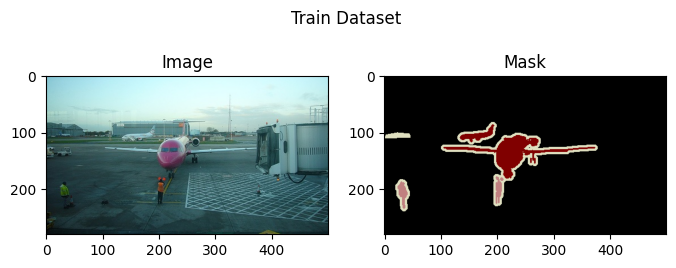

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
axs[0].imshow(train_dataset[0][0])
axs[1].imshow(train_dataset[0][1])
axs[0].set_title("Image")
axs[1].set_title("Mask")
fig.suptitle("Train Dataset")

Text(0.5, 0.98, 'Val Dataset')

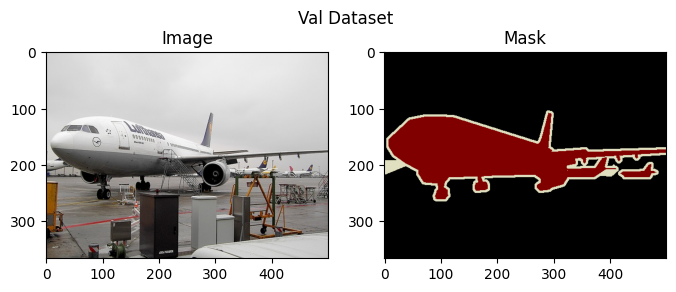

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
axs[0].imshow(val_dataset[0][0])
axs[1].imshow(val_dataset[0][1])
axs[0].set_title("Image")
axs[1].set_title("Mask")
fig.suptitle("Val Dataset")

In [4]:
class ToNumpy(object):
    def __init__(self):
        pass
    
    def __call__(self, img, target):
        img = np.asarray(img)
        target = np.asarray(target)
        return img, target

In [5]:
class ToTensor(object):
    def __init__(self):
        pass
    
    def __call__(self, img, target):
        img = torch.from_numpy(img)
        target = torch.from_numpy(target)
        return img, target

In [6]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms
        
    def __call__(self, img, target):
        for t in self.transforms:
            img, target = t(img, target)
        return img, target
    
    def __repr(self) -> str:
        format_string = self.__class__.__name__ + "("
        for t in self.transforms:
            format_string += "\n"
            format_string += f"    {t}"
        format_string += "\n)"
        return format_string

In [7]:
class NormalizeImage(object):
    def __init__(self, mean, std):
        self.__mean = mean
        self.__std = std
        
    def __call__(self, img, target):
        img = (img - self.__mean) / self.__std
        return img, target

In [8]:
import numpy as np

class PrepareForNet(object):
    def __init__(self):
        pass
    
    def __call__(self, img, target):
        img = np.transpose(img, (2, 0, 1))
        img = np.ascontiguousarray(img).astype(np.float32)
        
        target = target.astype(np.float32)
        target = np.ascontiguousarray(target)
        
        return img, target

In [9]:
import numpy as np
import cv2
import math

class Resize(object):
    """Resize sample to given size (width, height)."""

    def __init__(
        self,
        width,
        height,
        resize_target=True,
        keep_aspect_ratio=False,
        ensure_multiple_of=1,
        resize_method="lower_bound",
        image_interpolation_method=cv2.INTER_AREA,
    ):
        self.__width = width
        self.__height = height

        self.__resize_target = resize_target
        self.__keep_aspect_ratio = keep_aspect_ratio
        self.__multiple_of = ensure_multiple_of
        self.__resize_method = resize_method
        self.__image_interpolation_method = image_interpolation_method

    def constrain_to_multiple_of(self, x, min_val=0, max_val=None):
        y = (np.round(x / self.__multiple_of) * self.__multiple_of).astype(int)

        if max_val is not None and y > max_val:
            y = (np.floor(x / self.__multiple_of) * self.__multiple_of).astype(int)

        if y < min_val:
            y = (np.ceil(x / self.__multiple_of) * self.__multiple_of).astype(int)

        return y
    def get_size(self, width, height):
        # determine new height and width
        scale_height = self.__height / height
        scale_width = self.__width / width

        if self.__keep_aspect_ratio:
            if self.__resize_method == "lower_bound":
                # scale such that output size is lower bound
                if scale_width > scale_height:
                    # fit width
                    scale_height = scale_width
                else:
                    # fit height
                    scale_width = scale_height
            elif self.__resize_method == "upper_bound":
                # scale such that output size is upper bound
                if scale_width < scale_height:
                    # fit width
                    scale_height = scale_width
                else:
                    # fit height
                    scale_width = scale_height
            elif self.__resize_method == "minimal":
                # scale as least as possbile
                if abs(1 - scale_width) < abs(1 - scale_height):
                    # fit width
                    scale_height = scale_width
                else:
                    # fit height
                    scale_width = scale_height
            else:
                raise ValueError(
                    f"resize_method {self.__resize_method} not implemented"
                )

        if self.__resize_method == "lower_bound":
            new_height = self.constrain_to_multiple_of(
                scale_height * height, min_val=self.__height
            )
            new_width = self.constrain_to_multiple_of(
                scale_width * width, min_val=self.__width
            )
        elif self.__resize_method == "upper_bound":
            new_height = self.constrain_to_multiple_of(
                scale_height * height, max_val=self.__height
            )
            new_width = self.constrain_to_multiple_of(
                scale_width * width, max_val=self.__width
            )
        elif self.__resize_method == "minimal":
            new_height = self.constrain_to_multiple_of(scale_height * height)
            new_width = self.constrain_to_multiple_of(scale_width * width)
        else:
            raise ValueError(f"resize_method {self.__resize_method} not implemented")

        return (new_width, new_height)
    
    def __call__(self, img, target):
        width, height = self.get_size(
            img.shape[1], img.shape[0]
        )

        # resize sample
        img = cv2.resize(
            img,
            (width, height),
            interpolation=self.__image_interpolation_method,
        )

        if self.__resize_target:
            target = cv2.resize(
                target.astype(np.float32),
                (width, height),
                interpolation=cv2.INTER_NEAREST,
            )
            target = target.astype(bool)

        return img, target

In [10]:
import torchvision.transforms as T

t = Compose([
    ToNumpy(),
    Resize(
            NET_W,
            NET_H,
            resize_target=True,
            keep_aspect_ratio=False,
            ensure_multiple_of=32,
            resize_method="minimal",
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
    NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    PrepareForNet(),
    ToTensor()
])

In [32]:
train_dataset[0]

(<PIL.Image.Image image mode=RGB size=500x281>,
 <PIL.PngImagePlugin.PngImageFile image mode=P size=500x281>)

In [11]:
td = VOCSegmentation(root="./data", image_set="train", download=True, transforms=t)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [34]:
td

Dataset VOCSegmentation
    Number of datapoints: 1464
    Root location: ./data

In [35]:
img, target = td[0]
print(img.size(), target.size())

torch.Size([3, 480, 480]) torch.Size([480, 480])


In [36]:
minmax = lambda x: (x - x.min()) / (x.max() - x.min())

Text(0.5, 0.98, 'Train Dataset')

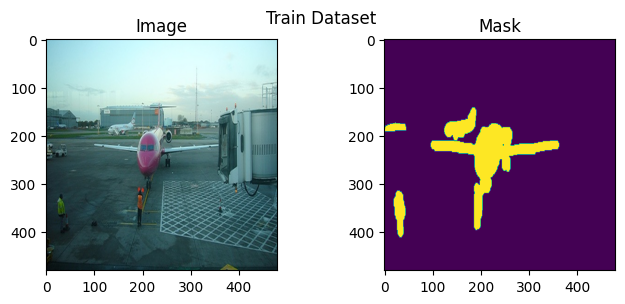

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
axs[0].imshow(minmax(td[0][0].permute(1, 2, 0)))
axs[1].imshow(td[0][1])
axs[0].set_title("Image")
axs[1].set_title("Mask")
fig.suptitle("Train Dataset")

In [12]:
vd = VOCSegmentation(root="./data", image_set="val", download=True, transforms=t)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [20]:
tl = DataLoader(td, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
vl = DataLoader(vd, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

NameError: name 'td' is not defined

In [11]:
criterion = BCEDiceLoss()

In [12]:
optimizer = partial(torch.optim.Adam, lr=0.0001)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [22]:
dpt = DPT(
    num_classes=20, 
    backbone=Backbone.VITL16_384, 
    criterion=criterion, 
    optimizer=optimizer, 
    enable_attention_hooks=True
)

{}
{}


In [23]:
dpt = dpt.to(device)

In [24]:
opt = torch.optim.Adam(dpt.parameters(), lr=0.0001)

In [25]:
dpt.train()

for images, targets in tl:
    images = images.to(device)
    targets = targets.to(device)
    
    opt.zero_grad()
    pred = dpt(images)

NameError: name 'tl' is not defined

In [40]:
trainer = pl.Trainer(accelerator="auto", devices=1, max_epochs=5, default_root_dir="./trial")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [41]:
torch.set_float32_matmul_precision('high')

In [42]:
trainer.fit(dpt, tl, vl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params
-------------------------------------------
0 | criterion  | BCEDiceLoss | 0     
1 | pretrained | Module      | 316 M 
2 | scratch    | Module      | 16.8 M
-------------------------------------------
332 M     Trainable params
0         Non-trainable params
332 M     Total params
1,331.765 Total estimated model params size (MB)


KeyError: '1'